# XLM Fine-Tuning with PyTorch

# 1. Setup

In [ ]:
!rm -r sample_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 1.1. Using Colab GPU for Training


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## 1.2. Installing the Hugging Face Library


In [ ]:
!pip install transformers

     |████████████████████████████████| 665kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 13.9MB/s 
     |████████████████████████████████| 890kB 19.1MB/s 
     |████████████████████████████████| 3.8MB 24.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=84eea2890ed8e6e8ec26592c4efeb8c97030bcb4339b1a6b18456c3dee49d957
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


The code in this notebook is actually a simplified version of the [run_glue.py](https://github.com/huggingface/transformers/blob/master/examples/run_glue.py) example script from huggingface.

`run_glue.py` is a helpful utility which allows you to pick which GLUE benchmark task you want to run on, and which pre-trained model you want to use (you can see the list of possible models [here](https://github.com/huggingface/transformers/blob/e6cff60b4cbc1158fbd6e4a1c3afda8dc224f566/examples/run_glue.py#L69)). It also supports using either the CPU, a single GPU, or multiple GPUs. It even supports using 16-bit precision if you want further speed up.

Unfortunately, all of this configurability comes at the cost of *readability*. In this Notebook, we've simplified the code greatly and added plenty of comments to make it clear what's going on. 

# 2. Loading the Dataset


## 2.1. Parse

In [ ]:
import numpy as np
train_file = "/content/drive/My Drive/Colab Notebooks/NLP/Projects/VarDial 2020 MOROCO/corpus/RDI-Train+Dev-VARDIAL2020/processed/train.tsv"

sentences = np.array([line.strip().split('\t')[0] for line in open(train_file)])
labels = np.array([line.strip().split('\t')[1] for line in open(train_file)])
labels = np.array(labels, dtype=int)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(len(sentences)))

Number of training sentences: 366,628



# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "cased" version of Multilingual BERT here, as it is recommended over the previous "uncased" one.


In [ ]:
from transformers import XLMTokenizer

# Load the XLM tokenizer.
print('Loading XLM tokenizer...')
tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-100-1280', do_lower_case=True)

Loading XLM tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  "[MASK] cum am spus, nu este un sfârșit de drum.
Tokenized:  ['"</w>', '[</w>', 'mas', 'k</w>', ']</w>', 'cum</w>', 'am</w>', 'spus</w>', ',</w>', 'nu</w>', 'este</w>', 'un</w>', 'sfârș', 'it</w>', 'de</w>', 'drum</w>', '.</w>']
Token IDs:  [16, 289, 1504, 314, 319, 14330, 239, 138687, 14, 1745, 803, 47, 154826, 62, 18, 31406, 15]


When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

## 3.2. Required Formatting

The above code left out a few required formatting steps that we'll look at here.

*Side Note: The input format to BERT seems "over-specified" to me... We are required to give it a number of pieces of information which seem redundant, or like they could easily be inferred from the data without us explicity providing it. But it is what it is, and I suspect it will make more sense once I have a deeper understanding of the BERT internals.*

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".



## 3.3. Tokenize Dataset

Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
import torch
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  "[MASK] cum am spus, nu este un sfârșit de drum.
Token IDs: tensor([     0,     16,    289,   1504,    314,    319,  14330,    239, 138687,
            14,   1745,    803,     47, 154826,     62,     18,  31406,     15,
             1,      2,      2,      2,      2,      2,      2,      2,      2,
             2,      2,      2,      2,      2,      2,      2,      2,      2,
             2,      2,      2,      2,      2,      2,      2,      2,      2,
             2,      2,      2,      2,      2,      2,      2,      2,      2,
             2,      2,      2,      2,      2,      2,      2,      2,      2,
             2,      2,      2,      2,      2,      2,      2,      2,      2,
             2,      2,      2,      2,      2,      2,      2,      2,      2,
             2,      2,      2,      2,      2,      2,      2,      2,      2,
             2,      2,      2,      2,      2,      2,      2,      2,      2,
             2,      2,      2,      2,      2,  

## 3.4. Training & Validation Split


Load the validation dataset.

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
val_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP/Projects/VarDial 2020 MOROCO/corpus/RDI-Train+Dev-VARDIAL2020/processed/dev-target.tsv", delimiter='\t', header=None, names=['sentence', 'label'])
# Report the number of sentences.
print('Number of validation sentences: {:,}\n'.format(val_df.shape[0]))

# Get the lists of sentences and their labels.
val_sentences = val_df.sentence.values
val_labels = val_df.label.values.astype(int)

# Tokenize all of the sentences and map the tokens to thier word IDs.
val_input_ids = []
val_attention_masks = []

# For every sentence...
for sent in val_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    val_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    val_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
import torch
val_input_ids = torch.cat(val_input_ids, dim=0)
val_attention_masks = torch.cat(val_attention_masks, dim=0)
val_labels = torch.tensor(val_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', val_sentences[0])
print('Token IDs:', val_input_ids[0])

Number of validation sentences: 215

Original:  Premierul îi ia apărarea ministrului [MASK] "Nu e în conflict de interese" [MASK]
Token IDs: tensor([     0,  49705,   1561,  48975,    283, 112188,    886, 100861,   4229,
           289,   1504,    314,    319,     16,   1745,     40,    788,  15630,
            18, 132089,     16,    289,   1504,    314,    319,      1,      2,
             2,      2,      2,      2,      2,      2,      2,      2,      2,
             2,      2,      2,      2,      2,      2,      2,      2,      2,
             2,      2,      2,      2,      2,      2,      2,      2,      2,
             2,      2,      2,      2,      2,      2,      2,      2,      2,
             2])


Divide up our training set to use 90% for training and 10% for validation.

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
train_dataset = dataset

val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

366,628 training samples
  215 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. BertForSequenceClassification



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


In [ ]:
# del df
del sentences
del labels
del dataset
del train_dataset
del val_dataset
del input_ids
del attention_masks

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from transformers import XLMForSequenceClassification, AdamW, BertConfig

# Load XLMRobertaForSequenceClassification model
model = XLMForSequenceClassification.from_pretrained(
    "xlm-mlm-100-1280", # Use the recommended Multilingual BERT model, with a cased vocab
    num_labels = 2, # The number of output labels -- 2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

XLMForSequenceClassification(
  (transformer): XLMModel(
    (position_embeddings): Embedding(512, 1280)
    (embeddings): Embedding(200000, 1280, padding_idx=2)
    (layer_norm_emb): LayerNorm((1280,), eps=1e-12, elementwise_affine=True)
    (attentions): ModuleList(
      (0): MultiHeadAttention(
        (q_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (k_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (v_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (out_lin): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (1): MultiHeadAttention(
        (q_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (k_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (v_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (out_lin): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (2): MultiHeadAttention(
        (q_lin): Linear(in_features=1280, 

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The XLM model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The XLM RoBERTa model has 262 different named parameters.

==== Embedding Layer ====

transformer.position_embeddings.weight                   (512, 1280)
transformer.embeddings.weight                           (200000, 1280)
transformer.layer_norm_emb.weight                            (1280,)
transformer.layer_norm_emb.bias                              (1280,)
transformer.attentions.0.q_lin.weight                   (1280, 1280)

==== First Transformer ====

transformer.attentions.0.q_lin.bias                          (1280,)
transformer.attentions.0.k_lin.weight                   (1280, 1280)
transformer.attentions.0.k_lin.bias                          (1280,)
transformer.attentions.0.v_lin.weight                   (1280, 1280)
transformer.attentions.0.v_lin.bias                          (1280,)
transformer.attentions.0.out_lin.weight                 (1280, 1280)
transformer.attentions.0.out_lin.bias                        (1280,)
transformer.attentions.1.q_lin.weight                 

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 3

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = int(0.06 * total_steps), # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a training phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Use GPU
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
# device = torch.device("cpu")

# model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 10 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB

======== Epoch 1 / 2 ========
Training...
  Batch    10  of  22,915.    Elapsed: 0:00:07.
  Batch    20  of  22,915.    Elapsed: 0:00:14.
  Batch    30  of  22,915.    Elapsed: 0:00:21.
  Batch    40  of  22,915.    Elapsed: 0:00:28.
  Batch    50  of  22,915.    Elapsed: 0:00:35.
  Batch    60  of  22,915.    Elapsed: 0:00:42.
  Batch    70  of  22,915.    Elapsed: 0:00:49.
  Batch    80  of  22,915.    Elapsed: 0:00:56.
  Batch    90  of  22,915.    Elapsed: 0:01:03.
  Batch   100  of  22,915.    Elapsed: 0:01:10.
  Batch   110  of  22,915.    Elapsed: 0:01:17.
  Batch   120  of  22,915.    Elapsed: 0:01:24.
  Batch   130  of  22,915.    Elapsed: 0:01:31.
  Batch   140  of  22,915.    Elapsed: 0:01:38.
  Batch   150  of  22,915.    Elapsed: 0:01:45.
  Batch   160  of  22,915.    Elapsed: 0:01:52.
  Batch   170  of  22,915.    Elapsed: 0:01:59.
  Batch   180  of  22,915.    Elapsed: 0:02:06.
  Batch   190  of  22

Save the trained model and the arguments it's been trained with.

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/My Drive/Colab Notebooks/NLP/Projects/VarDial 2020 MOROCO/xlm_v4/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)
# /content/model_save/pytorch_model.bin
# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/drive/My Drive/Colab Notebooks/NLP/Projects/VarDial 2020 MOROCO/xlm_v4/


('/content/drive/My Drive/Colab Notebooks/NLP/Projects/VarDial 2020 MOROCO/xlm_v4/vocab.json',
 '/content/drive/My Drive/Colab Notebooks/NLP/Projects/VarDial 2020 MOROCO/xlm_v4/merges.txt',
 '/content/drive/My Drive/Colab Notebooks/NLP/Projects/VarDial 2020 MOROCO/xlm_v4/special_tokens_map.json',
 '/content/drive/My Drive/Colab Notebooks/NLP/Projects/VarDial 2020 MOROCO/xlm_v4/added_tokens.json')

In [ ]:
# Programatically terminate session
!kill -9 -1

Let's view the summary of the training process.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.51,0.41,0.83,0:01:43,0:00:03
2,0.34,0.38,0.86,0:01:44,0:00:03
3,0.22,0.41,0.86,0:01:44,0:00:03
4,0.16,0.46,0.87,0:01:44,0:00:03


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

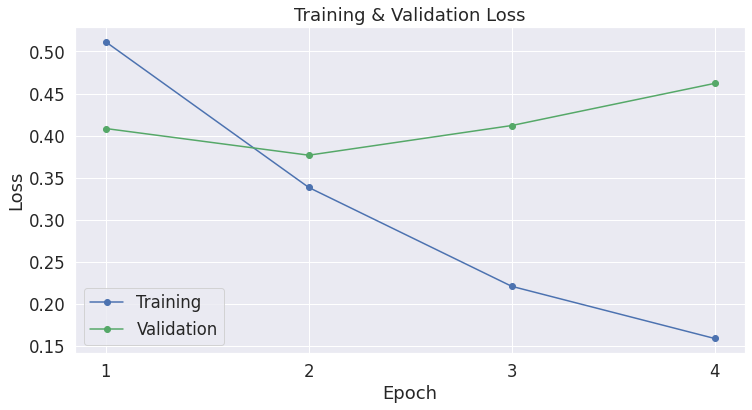

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [ ]:
!rm -r sample_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 645kB 2.9MB/s 
     |████████████████████████████████| 890kB 13.5MB/s 
     |████████████████████████████████| 3.8MB 16.6MB/s 
     |████████████████████████████████| 1.1MB 28.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=4456c105c23d09fd2b60c23ff0df616c085d30c88cc617e5fe8050e57c555d83
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import XLMForSequenceClassification, XLMTokenizer

# Load a trained model and vocabulary that you have fine-tuned
model = XLMForSequenceClassification.from_pretrained('/content/drive/My Drive/Colab Notebooks/NLP/Projects/VarDial 2020 MOROCO/xlm_v2')
tokenizer = XLMTokenizer.from_pretrained('/content/drive/My Drive/Colab Notebooks/NLP/Projects/VarDial 2020 MOROCO/xlm_v2', do_lower_case=True)

# Use GPU
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
# Tell pytorch to run this model on the GPU.
# model.cuda()

# Copy the model to the GPU.
model.to(device)

OSError: ignored

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP/Projects/VarDial 2020 MOROCO/corpus/RDI-Train+Dev-VARDIAL2020/processed/dev-target.tsv", delimiter='\t', header=None, names=['sentence', 'label'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 8  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 215



## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
import numpy as np
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.extend(logits)
  true_labels.extend(label_ids)

# predictions = np.argmax(predictions, axis=1).flatten()
from scipy.special import expit
predictions = expit(np.array(predictions)[:, 1])
print('    DONE.')

Predicting labels for 215 test sentences...
    DONE.


Compute the AUC and plot the ROC.

0.7055353114697206


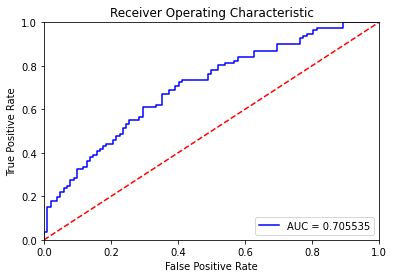

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

print(roc_auc)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Compute the F1 score.

In [ ]:
from sklearn.metrics import f1_score
print(f1_score(true_labels, [1 if prediction > 0.5 else 0 for prediction in predictions]))

0.546448087431694


In [ ]:
print(predictions)

[0.2548517  0.19815801 0.07825491 0.15641756 0.19005345 0.9694155
 0.06118598 0.5237824  0.29490042 0.04734658 0.31874016 0.6725386
 0.4232383  0.06316783 0.06214924 0.3395868  0.40070298 0.08071572
 0.36015415 0.07892191 0.5113926  0.3769305  0.91762197 0.39405227
 0.53673404 0.6623987  0.6968903  0.14655395 0.03887412 0.30445263
 0.08415613 0.25782406 0.04435166 0.24323508 0.42019323 0.6732202
 0.2239121  0.3782646  0.86860454 0.18940993 0.16600373 0.20895925
 0.11469945 0.65853024 0.25495464 0.23081028 0.13475174 0.46101993
 0.2623325  0.29549497 0.2019429  0.48121017 0.5054642  0.8515589
 0.9441724  0.705656   0.10939939 0.14869471 0.14363708 0.2395711
 0.5227238  0.3861707  0.09377104 0.153346   0.31803373 0.6391316
 0.3357363  0.2892288  0.61047286 0.4435083  0.97591305 0.1619528
 0.3029495  0.6349885  0.3745175  0.33421227 0.51023793 0.04399887
 0.0415217  0.4047284  0.75583166 0.14223665 0.11722406 0.12991135
 0.30065262 0.14971474 0.50487727 0.08634803 0.2695618  0.52202153
 0

# Appendix


## A1. Saving & Loading Fine-Tuned Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

Let's check out the file sizes, out of curiosity.

In [ ]:
!ls -l --block-size=K ./model_save/

total 427960K
-rw-r--r-- 1 root root      2K Mar 18 15:53 config.json
-rw-r--r-- 1 root root 427719K Mar 18 15:53 pytorch_model.bin
-rw-r--r-- 1 root root      1K Mar 18 15:53 special_tokens_map.json
-rw-r--r-- 1 root root      1K Mar 18 15:53 tokenizer_config.json
-rw-r--r-- 1 root root    227K Mar 18 15:53 vocab.txt


The largest file is the model weights, at around 418 megabytes.

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 418M Mar 18 15:53 ./model_save/pytorch_model.bin


To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/Shared drives/ChrisMcCormick.AI/Blog Posts/BERT Fine-Tuning/"

The following functions will load the model back from disk.

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

## A.2. Weight Decay



The huggingface example includes the following code block for enabling weight decay, but the default decay rate is "0.0", so I moved this to the appendix.

This block essentially tells the optimizer to not apply weight decay to the bias terms (e.g., $ b $ in the equation $ y = Wx + b $ ). Weight decay is a form of regularization--after calculating the gradients, we multiply them by, e.g., 0.99.

In [ ]:
# This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
no_decay = ['bias', 'LayerNorm.weight']

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

# Revision History

**Version 3** - *Mar 18th, 2020* - (current)
* Simplified the tokenization and input formatting (for both training and test) by leveraging the `tokenizer.encode_plus` function. 
`encode_plus` handles padding *and* creates the attention masks for us.
* Improved explanation of attention masks.
* Switched to using `torch.utils.data.random_split` for creating the training-validation split.
* Added a summary table of the training statistics (validation loss, time per epoch, etc.).
* Added validation loss to the learning curve plot, so we can see if we're overfitting. 
    * Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing this!
* Displayed the per-batch MCC as a bar plot.

**Version 2** - *Dec 20th, 2019* - [link](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP)
* huggingface renamed their library to `transformers`. 
* Updated the notebook to use the `transformers` library.

**Version 1** - *July 22nd, 2019*
* Initial version.

## Further Work

* It might make more sense to use the MCC score for “validation accuracy”, but I’ve left it out so as not to have to explain it earlier in the Notebook.
* Seeding -- I’m not convinced that setting the seed values at the beginning of the training loop is actually creating reproducible results…
* The MCC score seems to vary substantially across different runs. It would be interesting to run this example a number of times and show the variance.
